#  Revealing mesocale structures of time-varying networks through non-negative tensor factorization

In this notebook we show how the method presented in [[1]](#1) can be applied to data about face-to-face proximity relations collected in a school.

The data were collected by the [SocioPatterns collaboration](http://www.sociopatterns.org) using wearable proximity sensors that sense the face-to-face proximity relations of individuals wearing them. 

A few libraries are required in order to run this notebook. The Python Pandas library is used for data loading and manipulation, the `sktensor` library is used to represent the 3-way tensors and the `ncp` script contains the algorithms for the non-negative tensor factorization.

In [2]:
%pylab inline 

import pandas as pd
import sktensor

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [4]:
import ncp

In the following we load the expected structures (classes) that are used as a validation for the methodology.

The population of the school consisted of 231 children, organized in 10 classes, and 10 teachers.

In [5]:
classes = pd.read_csv("data/classes.csv", index_col=0, squeeze=True)
print(classes.size)
print(classes.unique() )

241
['cm1a' 'ce2b' 'cm2b' 'cm1b' 'ce1a' 'cm2a' 'teachers' 'cpb' 'ce1b' 'cpa'
 'ce2a']


The data collected through the SocioPatterns platorm is represented as triples $<t, i, j>$ where $i,j$ is a pair of nodes that were in proximity during the interval between time $t$ and $t+20$.

It represents 2 days of activity in a school. We selected only the hours when the kids were at school, for a total of 18 hours (two intervals of 9 hours per day concatenated as a single interval, thus removing the night).

In [6]:
data = pd.read_csv("data/school.csv.gz", compression="gzip")
print(data.head())
print(data.tail())
print(data.shape)

   t  i    j
0  0  0    1
1  0  0    2
2  0  0  222
3  0  1  222
4  0  2  228
            t    i    j
158570  64900  214  217
158571  64900  215  229
158572  64900  215  216
158573  64900  216  225
158574  64900  217  225
(158575, 3)


In [7]:
print( data.t.max() / 3600., "hours")

18.02777777777778 hours


From the timeline that shows the sum of number of contacts for each 20 seconds interval, we see that there is a small interval with no activity between the two 9 hours interval, in order to show where one day ends and starts the other.

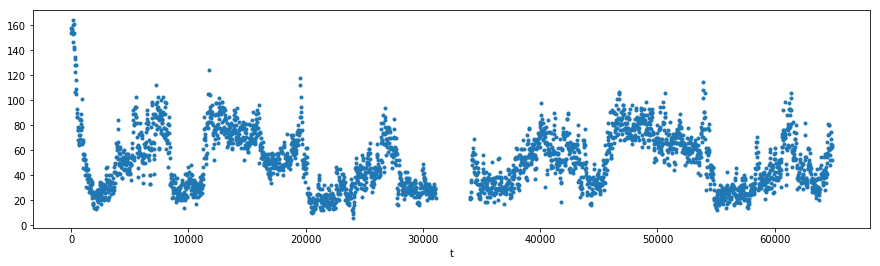

In [8]:
data.groupby(data.t).t.count().plot(linestyle='None', marker='.', figsize=(15,4));

In [9]:
NR_NODES = classes.index.unique().shape[0]
NR_INTERVALS = 150

print(NR_NODES)

241


For the purpose of this experiment, we divide the timeline in 150 different intervals.

In [10]:
data_binned = data.groupby((data.t / ((data.t.max()+1) / float(NR_INTERVALS))).astype(int))
print(data_binned.head(1)) #try tail
print(data_binned.tail(1))
#print(size(data_binned))
print(len(data_binned)) #get error

#NOT SURE WHAT THIS DOES, BINS WHAT?

            t   i    j
0           0   0    1
3133      440   6   85
4883      880   4   42
6075     1300   8   12
6844     1740   3  234
7358     2180   7   58
7890     2600   2   42
8562     3040   1  145
9240     3480   2  134
10089    3900   0  134
11312    4340   0  134
12393    4760   0  134
13457    5200   0  230
15222    5640   2  226
16505    6060   5   15
17878    6500   0  230
19344    6940   5  142
20996    7360   3  223
22847    7800   5  128
24595    8240   1  145
25642    8660   2    3
26271    9100   2  231
26827    9520   2  134
27463    9960   1  134
28247   10400   1  234
28839   10820   0  134
29543   11260   2  223
31120   11700  11  215
32996   12120   6   80
34690   12560   0  222
...       ...  ..  ...
129504  51940   1   64
130912  52360   1   68
132242  52800   3  233
133539  53220   1   68
134782  53660   1  159
136573  54100   1   68
137683  54520   4  234
138433  54960   6   12
138885  55400   8   83
139385  55820   7    8
139947  56260   6  237
140590  567

In [11]:
def create_adj(g):
    return g.groupby(['i', 'j']).size()

school_adj_series = data_binned.apply(create_adj)
school_adj_series.head(5)
school_adj_series.tail(20)
school_adj_series.shape

(55845,)

We transform the $<t, i, j>$ triples in a 3-way binary tensor.

In [12]:
triples = array([(i, j, t) for t, i, j in school_adj_series.keys()] + 
                [(j, i, t) for t, i, j in school_adj_series.keys()])
x = school_adj_series.keys() # this is levels=array 0 - 149, 0 - 240, 0 - 240
#print(x)

print(triples[1:10], triples[-10:-1])
print(triples.shape)

X = sktensor.sptensor(tuple(triples.T), ones(len(triples)),
                      shape=(NR_NODES, NR_NODES, NR_INTERVALS))

print(X.shape)
print(X[:, :, 1])

[[  0   2   0]
 [  0 222   0]
 [  1 219   0]
 [  1 222   0]
 [  2 219   0]
 [  2 228   0]
 [  2 231   0]
 [  3 134   0]
 [  3 232   0]] [[227 221 149]
 [227 225 149]
 [229 225 149]
 [229 227 149]
 [175 235 149]
 [182 235 149]
 [183 235 149]
 [ 90 236 149]
 [195 238 149]]
(111690, 3)
(241, 241, 150)
0


In [13]:
car = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

x = car.keys()

car["color"] = "white"

print(x)

dict_keys(['brand', 'model', 'year', 'color'])


In [15]:
from coreconsistency import corcondia

cc = []
for r in range(1, 20):
    cc.append(corcondia(X, components = r))
    print(cc[-1])
print(cc)

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


The tensor is factorized using the alternating non-negative least squares algorithm with the block principal pivoting method, proposed in [[2]](#2).

In [ ]:
np.random.seed(4)

X_approx_ks = ncp.nonnegative_tensor_factorization(X, 14, method='anls_bpp')

The result of the factorization is a set of loading matrices $\mathbf{A, B, C}$.

In [ ]:
A = X_approx_ks.U[0]
B = X_approx_ks.U[1]
C = X_approx_ks.U[2]

print(A, B, C)

We then group the rows of $\mathbf{A}$ by class and sum the values, in order to check how much of each class is represented in each one of the factors.

In [ ]:
dfa = pd.DataFrame(A).groupby(classes).sum()
dfa = dfa[dfa.index!='teachers']

plt.pcolormesh(dfa.values, cmap=plt.cm.Greys)
plt.xlim(0, dfa.shape[1])
plt.yticks(arange(10)+0.5, dfa.index)
plt.xticks(arange(14)+0.5, arange(1,15));

The activity timeline of each factor is represented in $\mathbf{C}$.

In [ ]:
figure(figsize=(10,4))
plt.pcolormesh(C.T, cmap=plt.cm.Greys)
plt.xlim(0,C.shape[0])
plt.yticks(arange(14)+0.5, arange(1,15));

We can also reorder the factors to show better the results of the factorization.

In [ ]:
factor_order = [1, 0, 7, 5, 3, 8, 12, 2, 11, 4, 6, 13, 9, 10]

In [ ]:
dfa = pd.DataFrame(A).groupby(classes).sum()
dfa = dfa[dfa.index!='teachers']

figure()
plt.pcolormesh(dfa.values[:, factor_order], cmap=plt.cm.Greys)
plt.xlim(0, dfa.shape[1])
plt.yticks(arange(10)+0.5, dfa.index)
plt.xticks(arange(14)+0.5, arange(1,15));

figure(figsize=(10,4))
plt.pcolormesh(C[:, factor_order[::-1]].T, cmap=plt.cm.Greys)
plt.xlim(0, C.shape[0])
plt.yticks(arange(14)+0.5, arange(14,0,-1));

References:

<a name="1"></a>[1] L. Gauvin, A. Panisson, C. Cattuto. [Detecting the Community Structure and Activity Patterns of Temporal Networks: A Non-Negative Tensor Factorization Approach](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0086028#pone-0086028-g001) PLOS ONE 9.1 (2014): e86028.

<a name="2"></a> [2] Kim J, Park H (2012) Fast nonnegative tensor factorization with an active-set-like method. In: Berry MW, Gallivan KA, Gallopoulos E, Grama A, Philippe B, et al., editors, High-Performance Scientific Computing, Springer London. 311–326.